# Dealing with Imbalanced Datasets

On this notebook we are going to apply some techniques in order to deal with imbalanced datasets and we will evaluate each one of them and see which one works best for each dataset

In [261]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, TunedThresholdClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, confusion_matrix, balanced_accuracy_score, classification_report

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import AllKNN, RandomUnderSampler, TomekLinks

import matplotlib.pyplot as plt

In [188]:
def model_eval(model_name, y_test, y_pred, y_pred_proba):
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    b_accuracy = balanced_accuracy_score(y_test, y_pred)

    scores = {'Model Name':model_name,
             'AUC-ROC':auc,
             'Accuracy':accuracy,
             'Recall':recall,
             'Precison':precision,
             'F1 Score':f1,
             'Balanced Accuracy':b_accuracy}

    return pd.DataFrame(scores, index=[0]) 

# Loading dataset

In [176]:
df = pd.read_csv('data/diabetes_binary_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# Preparing 

In [177]:
X = df.drop(columns=['Diabetes_binary'],axis=1)
y = df['Diabetes_binary']

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

# Baseline model

In [179]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [180]:
# Previsões de classe
y_pred = model.predict(X_test)

# Probabilidades para a classe positiva
y_pred_proba = model.predict_proba(X_test)[:, 0]

# Baseline model

In [198]:
bs_model_scores = model_eval('Baseline model', y_test, y_pred, y_pred_proba)
bs_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,Baseline model,0.20376,0.859272,0.173023,0.486014,0.255195,0.571699


# Tuned Threshold Model

In [196]:
tuned_treshold_model = TunedThresholdClassifierCV(
    model,
    scoring="f1",
    store_cv_results=True,
)

tuned_treshold_model.fit(X_train, y_train)

TunedThresholdClassifierCV(estimator=RandomForestClassifier(n_jobs=-1,
                                                            random_state=42),
                           scoring='f1', store_cv_results=True)

In [197]:
y_pred_tt = tuned_treshold_model.predict(X_test)
y_pred_proba_tt = tuned_treshold_model.predict_proba(X_test)[:,0]

In [199]:
tt_model_scores = model_eval('Tuned Treshold Model', y_test, y_pred_tt, y_pred_proba_tt)
tt_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,Tuned Treshold Model,0.203761,0.790602,0.588774,0.350394,0.439331,0.706026


## Over-sampling - SMOTE Model

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [202]:
model_smote = RandomForestClassifier(n_jobs=-1, random_state=42)

model_smote.fit(X_res, y_res)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [203]:
y_pred_smote = model_smote.predict(X_test)
y_pred_proba_smote = model_smote.predict_proba(X_test)[:,0]

In [220]:
smote_model_scores = model_eval('OS Smote Model', y_test, y_pred_smote, y_pred_proba_smote)
smote_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,OS Smote Model,0.205325,0.855692,0.196899,0.458498,0.275491,0.579625


## Over-sampling - RandomOverSampler

In [214]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

model_ros = RandomForestClassifier(n_jobs=-1, random_state=42)

model_ros.fit(X_res, y_res)

y_pred_ros = model_ros.predict(X_test)
y_pred_proba_ros = model_ros.predict_proba(X_test)[:,0]

In [221]:
ros_model_scores = model_eval('OS RandomOverSampler Model', y_test, y_pred_ros, y_pred_proba_ros)
ros_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,OS RandomOverSampler Model,0.206813,0.842337,0.309494,0.412394,0.35361,0.619049


## Over-sampling - ADASYN

In [217]:
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X_train, y_train)

model_ada = RandomForestClassifier(n_jobs=-1, random_state=42)

model_ada.fit(X_res, y_res)

y_pred_ada = model_ada.predict(X_test)
y_pred_proba_ada = model_ada.predict_proba(X_test)[:,0]

In [222]:
ada_model_scores = model_eval('OS ADASYN Model', y_test, y_pred_ada, y_pred_proba_ada)
ada_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,OS ADASYN Model,0.206478,0.85555,0.197465,0.457525,0.275868,0.57978


## Under-sampling - AllKNN

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.AllKNN.html

In [ ]:
allknn  = AllKNN()
X_res, y_res = allknn.fit_resample(X_train, y_train)

model_allknn = RandomForestClassifier(n_jobs=-1, random_state=42)

model_allknn.fit(X_res, y_res)

y_pred_allknn = model_allknn.predict(X_test)
y_pred_proba_allknn = model_allknn.predict_proba(X_test)[:,0]

In [235]:
allknn_model_scores = model_eval('UP AllKNN Model', y_test, y_pred_allknn, y_pred_proba_allknn)
allknn_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,UP AllKNN Model,0.193727,0.825591,0.498359,0.399202,0.443304,0.688465


## Under-sampling - RandomUnderSampler

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

In [229]:
rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

model_rus = RandomForestClassifier(n_jobs=-1, random_state=42)

model_rus.fit(X_res, y_res)

y_pred_rus = model_rus.predict(X_test)
y_pred_proba_rus = model_rus.predict_proba(X_test)[:,0]

In [236]:
rus_model_scores = model_eval('UP RandomUnderSampler Model', y_test, y_pred_rus, y_pred_proba_rus)
rus_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,UP RandomUnderSampler Model,0.206813,0.842337,0.309494,0.412394,0.35361,0.619049


## Under-sampling - TomekLinks

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.TomekLinks.html

In [237]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)

model_tl = RandomForestClassifier(n_jobs=-1, random_state=42)

model_tl.fit(X_res, y_res)

y_pred_tl = model_tl.predict(X_test)
y_pred_proba_tl = model_tl.predict_proba(X_test)[:,0]

In [238]:
tl_model_scores = model_eval('UP TomekLinks Model', y_test, y_pred_tl, y_pred_proba_tl)
tl_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,UP TomekLinks Model,0.20156,0.85801,0.22485,0.47972,0.306187,0.592684


# Results

In [279]:
results = pd.concat([bs_model_scores, tt_model_scores, smote_model_scores, ros_model_scores, ada_model_scores, allknn_model_scores, rus_model_scores, tl_model_scores])
results.sort_values('F1 Score', ascending=False)

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,UP AllKNN Model,0.193727,0.825591,0.498359,0.399202,0.443304,0.688465
0,Tuned Treshold Model,0.203761,0.790602,0.588774,0.350394,0.439331,0.706026
0,OS RandomOverSampler Model,0.206813,0.842337,0.309494,0.412394,0.353610,0.619049
0,UP RandomUnderSampler Model,0.206813,0.842337,0.309494,0.412394,0.353610,0.619049
0,UP TomekLinks Model,0.201560,0.858010,0.224850,0.479720,0.306187,0.592684
0,OS ADASYN Model,0.206478,0.855550,0.197465,0.457525,0.275868,0.579780
0,OS Smote Model,0.205325,0.855692,0.196899,0.458498,0.275491,0.579625
0,Baseline model,0.203760,0.859272,0.173023,0.486014,0.255195,0.571699


## Class-weight

In [266]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

model_cw = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight=weights_dict)

model_cw.fit(X_train, y_train)

y_pred_cw = model_tl.predict(X_test)
y_pred_proba_cw = model_tl.predict_proba(X_test)[:,0]

cw_model_scores = model_eval('Class Weight Model', y_test, y_pred_cw, y_pred_proba_cw)
cw_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,Class Weight Model,0.20156,0.85801,0.22485,0.47972,0.306187,0.592684


# Ensemble - AllKNN + TunedTreshold

In [260]:
allknn  = AllKNN()
X_res, y_res = allknn.fit_resample(X_train, y_train)

model_allknn = RandomForestClassifier(n_jobs=-1, random_state=42)

tt_allknn_model = TunedThresholdClassifierCV(
    model_allknn,
    scoring="f1",
    store_cv_results=True,
)

tt_allknn_model.fit(X_res, y_res)

y_pred_tt_allknn = tt_allknn_model.predict(X_test)
y_pred_proba_tt_allknn = tt_allknn_model.predict_proba(X_test)[:,0]

tta_model_scores = model_eval('Tuned Treshold + AllKNN Model', y_test, y_pred_tt_allknn, y_pred_proba_tt_allknn)
tta_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,Tuned Treshold + AllKNN Model,0.193728,0.778508,0.647165,0.343525,0.448813,0.723469


## Ensemble - TunedTreshold + Class-weight

In [269]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

model_cw = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight=weights_dict)

tt_cw_model = TunedThresholdClassifierCV(
    model_cw,
    scoring="f1",
    store_cv_results=True,
)

tt_cw_model.fit(X_res, y_res)

y_pred_tt_cw = tt_cw_model.predict(X_test)
y_pred_proba_tt_cw = tt_cw_model.predict_proba(X_test)[:,0]

tt_cw_model_scores = model_eval('Tuned Treshold + Class-weight Model', y_test, y_pred_tt_cw, y_pred_proba_tt_cw)
tt_cw_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,Tuned Treshold + Class-weight Model,0.194121,0.774819,0.653389,0.339807,0.447094,0.723934


## Ensemble - AllKNN + Class-weight

In [278]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

allknn  = AllKNN()
X_res, y_res = allknn.fit_resample(X_train, y_train)

model_allknn_cw = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight=weights_dict)

model_allknn_cw.fit(X_res, y_res)

y_pred_cw_allknn = model_allknn_cw.predict(X_test)
y_pred_proba_cw_allknn = model_allknn_cw.predict_proba(X_test)[:,0]

cw_allknn_model_scores = model_eval('Class-weight + AllKNN Model', y_test, y_pred_cw_allknn, y_pred_proba_cw_allknn)
cw_allknn_model_scores

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,Class-weight + AllKNN Model,0.194121,0.827688,0.48229,0.401507,0.438207,0.682949


In [280]:
results = pd.concat([results, tta_model_scores, cw_model_scores, tt_cw_model_scores, cw_allknn_model_scores])
results.sort_values('Recall', ascending=False)

,Model Name,AUC-ROC,Accuracy,Recall,Precison,F1 Score,Balanced Accuracy
0,Tuned Treshold + Class-weight Model,0.194121,0.774819,0.653389,0.339807,0.447094,0.723934
0,Tuned Treshold + AllKNN Model,0.193728,0.778508,0.647165,0.343525,0.448813,0.723469
0,Tuned Treshold Model,0.203761,0.790602,0.588774,0.350394,0.439331,0.706026
0,UP AllKNN Model,0.193727,0.825591,0.498359,0.399202,0.443304,0.688465
0,Class-weight + AllKNN Model,0.194121,0.827688,0.482290,0.401507,0.438207,0.682949
0,OS RandomOverSampler Model,0.206813,0.842337,0.309494,0.412394,0.353610,0.619049
0,UP RandomUnderSampler Model,0.206813,0.842337,0.309494,0.412394,0.353610,0.619049
0,UP TomekLinks Model,0.201560,0.858010,0.224850,0.479720,0.306187,0.592684
0,Class Weight Model,0.201560,0.858010,0.224850,0.479720,0.306187,0.592684
0,OS ADASYN Model,0.206478,0.855550,0.197465,0.457525,0.275868,0.579780


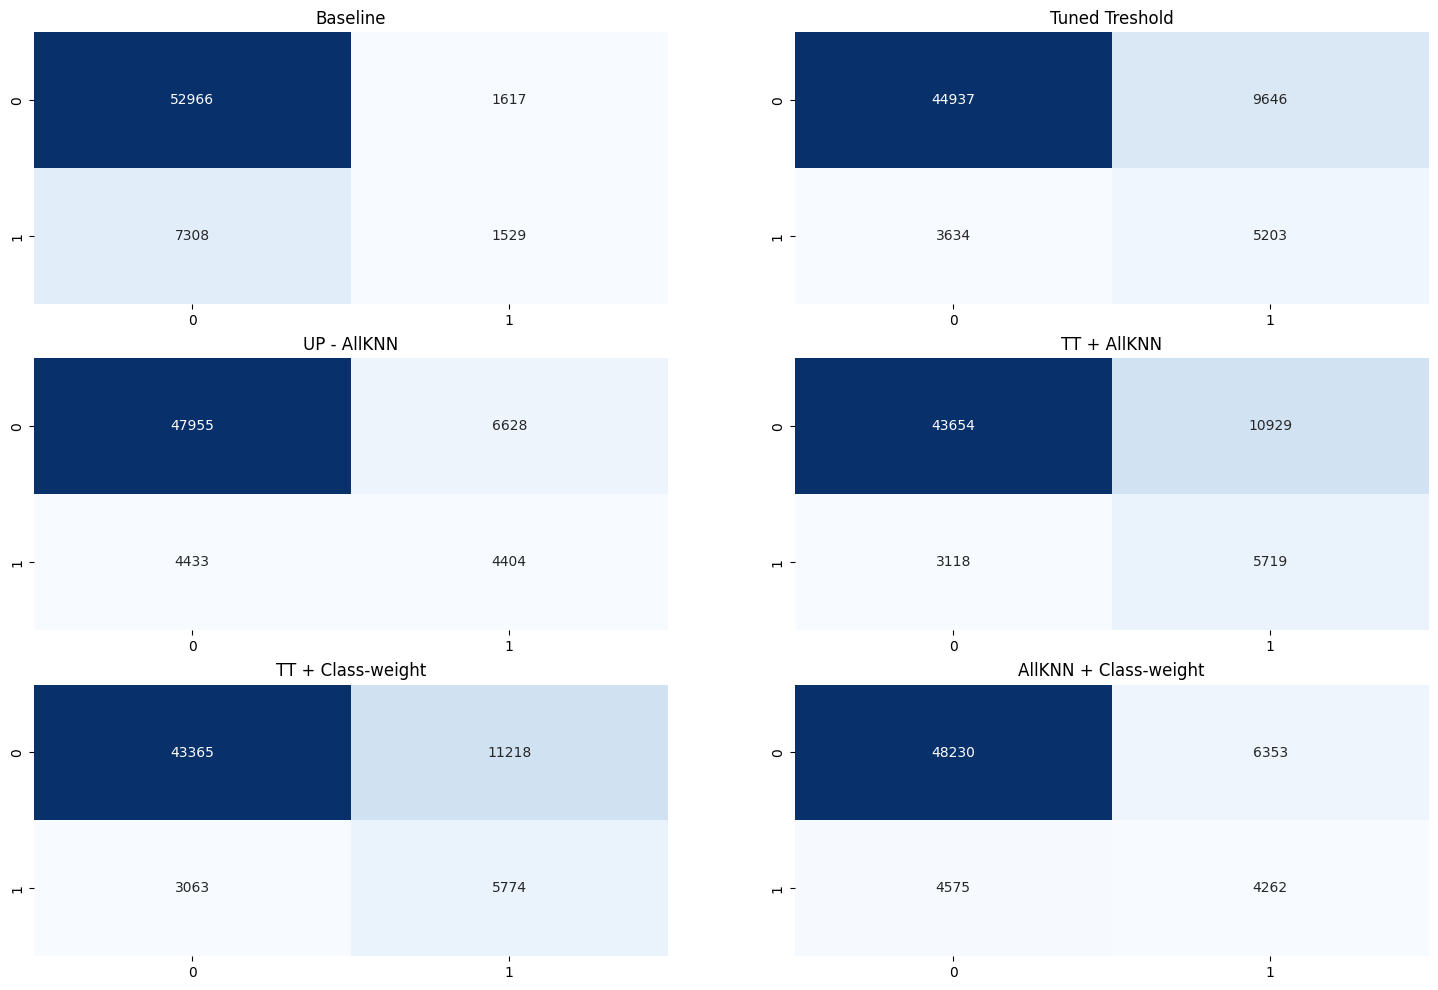

In [283]:
fig, axes = plt.subplots(3,2, figsize=(18,12))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0,0]);
axes[0,0].set_title('Baseline')

conf_matrix = confusion_matrix(y_test, y_pred_tt)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0,1]);
axes[0,1].set_title('Tuned Treshold')

conf_matrix = confusion_matrix(y_test, y_pred_allknn)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1,0]);
axes[1,0].set_title('UP - AllKNN')

conf_matrix = confusion_matrix(y_test, y_pred_tt_allknn)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1,1]);
axes[1,1].set_title('TT + AllKNN')

conf_matrix = confusion_matrix(y_test, y_pred_tt_cw)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[2,0]);
axes[2,0].set_title('TT + Class-weight')

conf_matrix = confusion_matrix(y_test, y_pred_cw_allknn)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[2,1]);
axes[2,1].set_title('AllKNN + Class-weight')

#plt.tight_layout()
plt.show()